# apply instruments settings

In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np

In [2]:
# connect to devices
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [3]:
current_percent = 75.09
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [4]:
# laserpower = 1.0
# laser.laser_off()
# laser.set_analog_control_mode("power")
# laser.set_modulation_state("CW")
# laser.set_laser_power(laserpower, save_memory=False)
# # laser.laser_on()

In [5]:
freq = 16.6
errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.6 GHz
Actual Output CW Freqeuncy :16.600000005215406 GHz


In [6]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0.0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [7]:
dur_pt = 16E6 # duration of each frequency point
divpart_pt = 2 
clock_rate = 500E-6 #GHz
daqtrig_delay = 1/clock_rate #delay
seq_daqtrig = [(dur_pt/2.0, HIGH), (dur_pt/2.0, LOW)]
seq_laser = [(dur_pt, HIGH)]
seq_mwA = [(dur_pt/2.0/divpart_pt, HIGH), (dur_pt/2.0/divpart_pt, LOW)]*divpart_pt
seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*int(dur_pt*clock_rate)


pg.setDigital("laser", seq_laser)
pg.setDigital("mwA", seq_mwA)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
pg.setDigital("dtrig", seq_daqtrig)
pg.setDigital("dclk", seq_clock)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)

In [8]:
# signal reading parameters
min_volt = -0.004 # [V]
max_volt = 0.006
samplerate_read = clock_rate*1E9 # 500kHz .max ext clock rate of NI6343
basetime = 1.0/samplerate_read
num_readsample = int(samplerate_read*dur_pt/1E9)
timeout_read = max(dur_pt*2.0/1E9, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hcf.NI_ch_APD,"",
            # TerminalConfiguration.RSE,
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
readtask.timing.cfg_samp_clk_timing(samplerate_read, source=hcf.NI_ch_Clock, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
        # reader = stream_readers.AnalogMultiChannelReader(task.in_stream)
reader.read_all_avail_samp  = True
divnum = int(len(buffer_readpoint)/divpart_pt)
recordlen = int(divnum/2)

# Start measurement


In [9]:
laser.laser_on() # turn off laser
pg.stream(n_runs=INF)
pg.startNow()

0

In [10]:
freq_start = 16.45-0.25
freq_stop = 16.45+0.25
B = 14.103
f_e = 28.0249514242*B
f_NVp1 = f_e + 2.8705
f_NVm1 = f_e - 2.8705
# f_NVguess = 392.8397714495659
f_NVguess = 398.5567714869976
freq_start = (f_NVguess-0.030)/24.0
freq_stop = (f_NVguess+0.030)/24.0
# check the minium step size
freqminstep_list = mwsyn.get_min_step_size([freq_start], [freq_stop])
step_min = freqminstep_list[0] # in Hz
freq_step = 0.5E-3/24.0
freq_step = int(freq_step/step_min*1E9)*step_min/1E9

freq_array = np.arange(freq_start, freq_stop, freq_step)
print(f"Estimated time for one sweep:{(freq_stop-freq_start)/freq_step*max(10E6, dur_pt)/1E9} s")
freq_actual = np.zeros(len(freq_array))

# sigref = np.zeros((len(freq_array), num_readsample), dtype=np.float64, order='C')
signal = np.zeros(len(freq_actual))
background = np.zeros(len(freq_actual))
# repeat measurement
num_repeat = 2
signal_av = np.zeros(len(freq_actual))
background_av = np.zeros(len(freq_actual))

for kkk in range(num_repeat):
    for (jj, ff) in enumerate(freq_array):
        errorbyte, freq_actual[jj] = mwsyn.cw_frequency(ff)
        # print(f"CW Freqeuncy Setting Sent:{freq} GHz")
        # print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")
        readtask.start() # ready to read data
        num_read = reader.read_many_sample(
                buffer_readpoint,
                num_readsample,
                timeout_read
            )
        bright = 0.0
        dark = 0.0
        for ii in range(divpart_pt):
            bright += np.mean(buffer_readpoint[1+ii*divnum:1+ii*divnum+recordlen])
            dark += np.mean(buffer_readpoint[1+ii*divnum+recordlen:1+(ii+1)*divnum])
        # sigref[jj] = np.copy(buffer_readpoint)
        signal[jj] = bright
        background[jj] = dark
        readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
        readtask.stop()
        # laser.laser_off()
        # readtask.close()
    signal_av += np.copy(signal)
    background_av += np.copy(background)
signal_av = signal_av/num_repeat/divpart_pt
background_av = background_av/num_repeat/divpart_pt
contrast = (signal_av-background_av)/background_av

Estimated time for one sweep:1.920139170241458 s


In [11]:
# turn off laser and set diode current to zero
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()
# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()
# pg.reboot()

# close all NI tasks
readtask.stop()
readtask.close()
task_uca.stop()
task_uca.close()

# reboot(optional) and close the MW synthesizer 
# mwsyn.reboot()
mwsyn.close()

Failed to set command 'CM=0'
Response from Device :'CM=0.00'


Guess NV transition: 392.8387693762779GHz


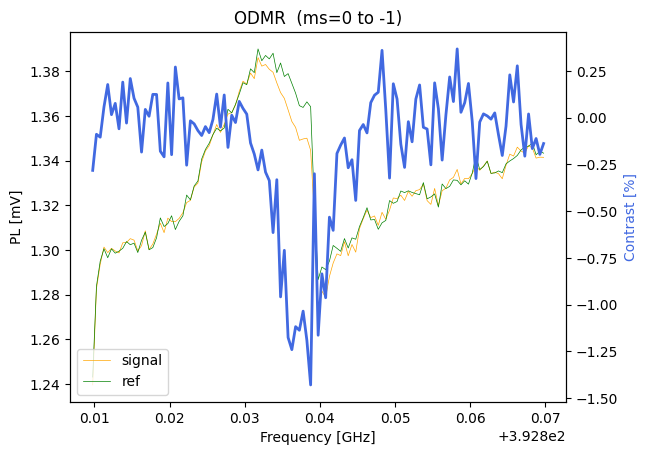

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
idx = np.argmin(contrast)
print(f"Guess NV transition: {freq_actual[idx]*24}GHz")
ax2 = ax1.twinx()
ax1.plot(freq_actual*24.0, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(freq_actual*24.0, background_av*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(freq_actual*24.0, contrast*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("Frequency [GHz]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='lower left')
plt.title("ODMR  (ms=0 to +1)")
plt.show()

In [13]:
np.savetxt('output\\20240930_return\\ODMR.txt', np.c_[freq_actual*24, signal_av, background_av])

In [14]:
# to save file
# Data to save
import pickle
data = {
    'freq_actual': freq_actual*24.0,
    'signal_av': signal_av,
    'background_av': background_av, 
    'contrast': contrast, 
}

# File path
filename = f"p1ODMR_ccw.pkl"
dir = "output\\20240511_cwodmr"
file_path = f'{dir}\\{filename}'

# Open the file in binary write mode
with open(file_path, 'wb') as f:
    # Write data to the file using pickle.dump()
    pickle.dump(data, f)

print(f'Data saved to {file_path}')

Data saved to output\20240511_cwodmr\p1ODMR_ccw.pkl


In [15]:
# functions for fitting =============================
def lorentzian_bg(x, A, x0, gamma, B):
    # lorentzian with background floor
    return 0.5*A*gamma/np.pi/(np.square(x-x0)+np.square(0.5*gamma)) + B

def lorentzian(x, A, x0, gamma):
    return lorentzian_bg(x, A, x0, gamma, 0.0)

def lorentzian_slopebg(x, A, x0, gamma, m, B):
    # lorentzian with background floor
    return 0.5*A*gamma/np.pi/(np.square(x-x0)+np.square(0.5*gamma)) + m*x + B

def lorentzian_slopebg_estimator(xdata, ydata):
    slope = (ydata[-1]-ydata[0])/(xdata[-1]-xdata[0])

    ydata = np.array(ydata) - slope*(np.array(xdata)-xdata[0])
    idxmax = np.argmax(ydata)
    idxmin = np.argmin(ydata)
    ymin = np.min(ydata)
    ymax = np.max(ydata)
    # ydata = (ydata-ymin)/(ymax-ymin)
    baseline = np.median(ydata)
    # baseline = np.square(np.median(np.sqrt(ydata)))
    pospeak = (ymax-baseline)>(baseline-ymin)
    A = (ymax-baseline)*pospeak + (ymin-baseline)*(not pospeak)
    idxpeak = idxmax*pospeak + idxmin*(not pospeak)
    x0 = xdata[idxpeak]
    idxhalf = np.argmin(np.absolute(ydata-A/2))
    gamma = abs(xdata[idxhalf]-xdata[idxpeak])
    return A*gamma, x0, gamma, slope, baseline


def lorentzian_bg_estimator(xdata, ydata):
    idxmax = np.argmax(ydata)
    idxmin = np.argmin(ydata)
    ymin = np.min(ydata)
    ymax = np.max(ydata)
    # ydata = (ydata-ymin)/(ymax-ymin)
    baseline = np.median(ydata)
    # baseline = np.square(np.median(np.sqrt(ydata)))
    pospeak = (ymax-baseline)>(baseline-ymin)
    A = (ymax-baseline)*pospeak + (ymin-baseline)*(not pospeak)
    idxpeak = idxmax*pospeak + idxmin*(not pospeak)
    x0 = xdata[idxpeak]
    idxhalf = np.argmin(np.absolute(ydata-A/2))
    gamma = abs(xdata[idxhalf]-xdata[idxpeak])
    return A, x0, gamma, baseline

def lorentzian_estimator(xdata, ydata):
    return lorentzian_bg_estimator(xdata, ydata)[:-1]